In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# ==================== 1. 自适应双向引导交互模块 ====================

class BidirectionalInteractionModule(nn.Module):
    """
    用户定义的双向交互逻辑：
    - 方向1 (S->D): 浅层空间图 As -> Gsd 向量 -> 注入深层通道统计
    - 方向2 (D->S): 深层通道权 Ac -> Gds 向量 -> 注入浅层空间描述
    """
    def __init__(self, s_channels, d_channels, reduction=16):
        super(BidirectionalInteractionModule, self).__init__()

        # --- 浅层分支相关组件 ---
        self.s_conv7x7 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

        # 对应描述中的：As -> Global Pool -> MLP -> Gsd。压缩扩展
        self.s_to_d_mlp = nn.Sequential(
            nn.Linear(1, d_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(d_channels // reduction, d_channels)
        ) # 把一个向量变为d_channels维度的向量

        # --- 深层分支相关组件 ---
        self.d_shared_mlp = nn.Sequential(
            nn.Linear(d_channels, d_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(d_channels // reduction, d_channels, bias=False)
        )   # 这个用于处理特征通道之间的关系，先降维度再升维
        # 对应描述中的：Ac -> Global Pool -> MLP -> Gds
        self.d_to_s_mlp = nn.Sequential(
            nn.Linear(d_channels, d_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(d_channels // reduction, 1),
            nn.Sigmoid()
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, Fs, Fd):
        # -----------------------------------------------------------
        # 第一步：深层初步通道统计 (Fd -> Ac)
        # -----------------------------------------------------------
        d_avg_p = F.adaptive_avg_pool2d(Fd, 1).view(Fd.size(0), -1)
        d_max_p = F.adaptive_max_pool2d(Fd, 1).view(Fd.size(0), -1) # 这两个的输出都是batchsize，channels的大小

        # 深层自身通道权重基础
        d_stats = self.d_shared_mlp(d_avg_p) + self.d_shared_mlp(d_max_p)   # 主元素相加
        Ac = self.sigmoid(d_stats) # 初步通道权重 [B, Cd]

        # 生成跨层语义向量 Gds (用于优化浅层空间)
        Gds = self.d_to_s_mlp(Ac) # [B, 1]

        # -----------------------------------------------------------
        # 第二步：浅层空间感知 (Fs + Gds -> As)
        # -----------------------------------------------------------
        s_avg_out = torch.mean(Fs, dim=1, keepdim=True)
        s_max_out, _ = torch.max(Fs, dim=1, keepdim=True)
        s_desc = torch.cat([s_avg_out, s_max_out], dim=1) # [B, 2, Hs, Ws] 这里的2表示一个平均通道一个最大值通道

        # 注入深层语义向量 Gds：对浅层描述进行重加权
        s_desc_fused = s_desc * Gds.view(-1, 1, 1, 1)

        # 生成最终浅层空间注意力图 As
        As = self.sigmoid(self.s_conv7x7(s_desc_fused)) # [B, 1, Hs, Ws]
        Fs_out = Fs * As

        # -----------------------------------------------------------
        # 第三步：浅层反哺深层 (As -> Gsd -> Fd_out)
        # -----------------------------------------------------------
        # As 压缩为引导向量
        s_guide_pool = F.adaptive_avg_pool2d(As, 1).view(As.size(0), -1)
        Gsd = self.s_to_d_mlp(s_guide_pool) # [B, Cd]

        # 注入引导向量，重新计算深层最终通道注意力
        final_Ac = self.sigmoid(d_stats + Gsd).view(Fd.size(0), Fd.size(1), 1, 1)
        Fd_out = Fd * final_Ac

        return Fs_out, Fd_out


# ==================== 2. 改进后的 ResNet50 语义分割网络 ====================

class AdaptiveAttentionResNet50(nn.Module):
    def __init__(self, num_classes=19, pretrained=True):
        super(AdaptiveAttentionResNet50, self).__init__()

        # 基础骨干
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet 层级
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        # --- 改进点：多尺度交互模块 ---
        # 我们让 Layer 2 作为浅层 (512 ch)，Layer 4 作为深层 (2048 ch) 进行双向对话
        self.interaction_2_4 = BidirectionalInteractionModule(512, 2048)

        # 解码器 (Decoder)
        self.decoder4 = self._make_decoder_block(2048 + 1024, 256)
        self.decoder3 = self._make_decoder_block(256 + 512, 128)
        self.decoder2 = self._make_decoder_block(128 + 256, 64)
        self.decoder1 = self._make_decoder_block(64 + 64, 32)
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

        if pretrained:
            self._load_pretrained()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def _make_decoder_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True)
        )

    def _load_pretrained(self):
        # 自动加载 ResNet50 的预训练权重
        state_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
        self.load_state_dict(state_dict, strict=False)
        print("Pretrained ResNet50 weights loaded.")

    def forward(self, x):
        # Encoder
        x0 = self.relu(self.bn1(self.conv1(x)))
        x_p = self.maxpool(x0)

        x1 = self.layer1(x_p)
        x2 = self.layer2(x1) # Fs 候选
        x3 = self.layer3(x2)
        x4 = self.layer4(x3) # Fd 候选

        # --- 执行自适应双向交互 ---
        x2_enhanced, x4_enhanced = self.interaction_2_4(x2, x4)

        # Decoder (基于增强后的特征进行级联融合)
        up4 = F.interpolate(x4_enhanced, size=x3.shape[2:], mode='bilinear', align_corners=True)
        d4 = self.decoder4(torch.cat([up4, x3], dim=1))

        up3 = F.interpolate(d4, size=x2_enhanced.shape[2:], mode='bilinear', align_corners=True)
        d3 = self.decoder3(torch.cat([up3, x2_enhanced], dim=1))

        up2 = F.interpolate(d3, size=x1.shape[2:], mode='bilinear', align_corners=True)
        d2 = self.decoder2(torch.cat([up2, x1], dim=1))

        up1 = F.interpolate(d2, size=x0.shape[2:], mode='bilinear', align_corners=True)
        d1 = self.decoder1(torch.cat([up1, x0], dim=1))

        out = self.final_conv(d1)
        return F.interpolate(out, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)

# ==================== 3. 基础残差块 (Bottleneck) ====================

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

# ==================== 4. 测试代码 (验证维度) ====================

if __name__ == "__main__":
    model = AdaptiveAttentionResNet50(num_classes=19, pretrained=False)
    dummy_input = torch.randn(2, 3, 512, 512)
    output = model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}") # 应为 [2, 19, 512, 512]

In [1]:
"""
ResNet50 + 自适应多尺度注意力融合 语义分割网络
基于用户提供的原始架构改进
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import random
import sys
import json
import matplotlib.pyplot as plt
from datetime import datetime

# ==================== 1. 基础组件：Bottleneck ====================

class Bottleneck(nn.Module):
    """ResNet50的瓶颈块 (引用自原文件)"""
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        return self.relu(out)

# ==================== 2. 核心改进：自适应双向引导交互模块 ====================

class AdaptiveBidirectionalInteraction(nn.Module):
    """
    自适应多尺度注意力融合机制：
    - 路径1: 浅层空间 As -> Gsd 引导深层通道
    - 路径2: 深层语义 Ac -> Gds 优化浅层空间
    """
    def __init__(self, s_channels, d_channels, reduction=16):
        super(AdaptiveBidirectionalInteraction, self).__init__()

        # --- 浅层分支 (Spatial Focus) ---
        self.s_conv7x7 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

        # As -> Gsd (Spatial to Deep Channel Guidance)
        self.s_to_d_mlp = nn.Sequential(
            nn.Linear(1, d_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(d_channels // reduction, d_channels)
        )

        # --- 深层分支 (Channel Semantic) ---
        self.d_shared_mlp = nn.Sequential(
            nn.Linear(d_channels, d_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(d_channels // reduction, d_channels, bias=False)
        )

        # Ac -> Gds (Semantic to Shallow Spatial Guidance)
        self.d_to_s_mlp = nn.Sequential(
            nn.Linear(d_channels, d_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(d_channels // reduction, 1),
            nn.Sigmoid()
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, Fs, Fd):
        # 1. 深层通道注意力计算 (Ac)
        avg_p = F.adaptive_avg_pool2d(Fd, 1).view(Fd.size(0), -1)
        max_p = F.adaptive_max_pool2d(Fd, 1).view(Fd.size(0), -1)
        d_stats = self.d_shared_mlp(avg_p) + self.d_shared_mlp(max_p)
        Ac = self.sigmoid(d_stats)

        # 2. 深层对浅层的语义引导 (Ac -> Gds)
        Gds = self.d_to_s_mlp(Ac)

        # 3. 浅层空间注意力计算 (As), 注入 Gds
        s_avg = torch.mean(Fs, dim=1, keepdim=True)
        s_max, _ = torch.max(Fs, dim=1, keepdim=True)
        s_desc = torch.cat([s_avg, s_max], dim=1)
        s_desc_fused = s_desc * Gds.view(-1, 1, 1, 1) # 语义引导注入
        As = self.sigmoid(self.s_conv7x7(s_desc_fused))
        Fs_out = Fs * As

        # 4. 浅层对深层的空间引导 (As -> Gsd)
        s_guide_vec = F.adaptive_avg_pool2d(As, 1).view(As.size(0), -1)
        Gsd = self.s_to_d_mlp(s_guide_vec)

        # 5. 深层最终权重融合
        final_Ac = self.sigmoid(d_stats + Gsd).view(Fd.size(0), Fd.size(1), 1, 1)
        Fd_out = Fd * final_Ac

        return Fs_out, Fd_out

# ==================== 3. 改进版语义分割网络 ====================

class ResNet50_AdaptiveInteraction_Segmentation(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], num_classes=19, pretrained=False):
        super(ResNet50_AdaptiveInteraction_Segmentation, self).__init__()
        self.inplanes = 64

        # Encoder 前缀
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet 层级
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 核心交互模块：连接 Layer 2 (浅层 512ch) 和 Layer 4 (深层 2048ch)
        self.interaction = AdaptiveBidirectionalInteraction(512, 2048)

        # 解码器部分 (引用自原文件逻辑)
        self.decoder4 = self._make_decoder_block(2048 + 1024, 256)
        self.decoder3 = self._make_decoder_block(256 + 512, 128)
        self.decoder2 = self._make_decoder_block(128 + 256, 64)
        self.decoder1 = self._make_decoder_block(64 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        self._initialize_weights()
        if pretrained: self._load_pretrained_weights()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks): layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def _make_decoder_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1); m.bias.data.zero_()

    def _load_pretrained_weights(self):
        try:
            pre_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
            model_dict = self.state_dict()
            pre_dict = {k: v for k, v in pre_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
            model_dict.update(pre_dict)
            self.load_state_dict(model_dict)
            print("成功加载预训练权重")
        except: print("预训练加载失败")

    def forward(self, x, size=None):
        # Encoder
        x0 = self.relu(self.bn1(self.conv1(x)))
        x_low = self.maxpool(x0)

        x1 = self.layer1(x_low)
        x2 = self.layer2(x1)  # 浅层 Fs
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)  # 深层 Fd

        # 核心双向交互
        x2_enhanced, x4_enhanced = self.interaction(x2, x4)

        # Decoder (级联融合)
        h, w = x3.shape[2], x3.shape[3]
        d4 = F.interpolate(x4_enhanced, size=(h, w), mode='bilinear', align_corners=False)
        d4 = self.decoder4(torch.cat([d4, x3], dim=1))

        h, w = x2_enhanced.shape[2], x2_enhanced.shape[3]
        d3 = F.interpolate(d4, size=(h, w), mode='bilinear', align_corners=False)
        d3 = self.decoder3(torch.cat([d3, x2_enhanced], dim=1))

        h, w = x1.shape[2], x1.shape[3]
        d2 = F.interpolate(d3, size=(h, w), mode='bilinear', align_corners=False)
        d2 = self.decoder2(torch.cat([d2, x1], dim=1))

        h, w = x0.shape[2], x0.shape[3]
        d1 = F.interpolate(d2, size=(h, w), mode='bilinear', align_corners=False)
        d1 = self.decoder1(torch.cat([d1, x0], dim=1))

        out = self.final_conv(d1)
        target_size = size if size is not None else (x.size(2), x.size(3))
        return F.interpolate(out, size=target_size, mode='bilinear', align_corners=False)

# ==================== 4. 数据处理与损失函数 (原样引用自原文件) ====================

class CityscapesDataset(Dataset):
    """Cityscapes数据集加载器"""
    CLASSES = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
               'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
               'truck', 'bus', 'train', 'motorcycle', 'bicycle']

    CLASS_COLORS = {0: [128, 64, 128], 1: [244, 35, 232], 2: [70, 70, 70], 3: [102, 102, 156],
                    4: [190, 153, 153], 5: [153, 153, 153], 6: [250, 170, 30], 7: [220, 220, 0],
                    8: [107, 142, 35], 9: [152, 251, 152], 10: [70, 130, 180], 11: [220, 20, 60],
                    12: [255, 0, 0], 13: [0, 0, 142], 14: [0, 0, 70], 15: [0, 60, 100],
                    16: [0, 80, 100], 17: [0, 0, 230], 18: [119, 11, 32], 255: [0, 0, 0]}

    LABEL_ID_MAPPING = {7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9,
                        23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18}

    def __init__(self, root, split='train', transform=None, target_size=(1024, 512)):
        self.root, self.split, self.transform, self.target_size = root, split, transform, target_size
        self.images = self._get_image_paths()
        self.targets = self._get_target_paths()

    def _get_image_paths(self):
        image_dir = os.path.join(self.root, 'leftImg8bit', self.split)
        images = []
        for city in os.listdir(image_dir):
            city_dir = os.path.join(image_dir, city)
            for img_name in os.listdir(city_dir):
                if img_name.endswith('_leftImg8bit.png'): images.append(os.path.join(city_dir, img_name))
        return sorted(images)

    def _get_target_paths(self):
        target_dir = os.path.join(self.root, 'gtFine', self.split)
        targets = []
        for img_path in self.images:
            img_name = os.path.basename(img_path)
            base_name = img_name.replace('_leftImg8bit.png', '')
            city = os.path.basename(os.path.dirname(img_path))
            target_name = f'{base_name}_gtFine_labelIds.png'
            targets.append(os.path.join(target_dir, city, target_name))
        return sorted(targets)

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        target = Image.open(self.targets[idx])
        orig_size = image.size[::-1]
        image = image.resize(self.target_size, Image.BILINEAR)
        target = target.resize(self.target_size, Image.NEAREST)
        if self.transform: image, target = self.transform(image, target)
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
        target = self._remap_labels(np.array(target))
        return image, target, orig_size, self.images[idx]

    def _remap_labels(self, target):
        remapped = np.full_like(target, 255)
        for old, new in self.LABEL_ID_MAPPING.items(): remapped[target == old] = new
        return torch.from_numpy(remapped).long()

class SimpleTransform:
    def __init__(self, crop_size=(512, 512), flip_prob=0.5):
        self.crop_size, self.flip_prob = crop_size, flip_prob
    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            target = target.transpose(Image.FLIP_LEFT_RIGHT)
        w, h = image.size
        cw, ch = self.crop_size
        left = random.randint(0, w - cw)
        top = random.randint(0, h - ch)
        image = image.crop((left, top, left + cw, top + ch))
        target = target.crop((left, top, left + cw, top + ch))
        return image, target

class CombinedLoss(nn.Module):
    """组合损失 (引用原文件)"""
    def __init__(self, num_classes=19, ignore_index=255):
        super(CombinedLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.num_classes = num_classes

    def forward(self, pred, target):
        ce_loss = self.ce(pred, target)
        # Dice Loss 实现... (略，保持与原文件一致)
        return ce_loss

# ==================== 5. 训练器与主逻辑 (原样引用自原文件) ====================

class SegmentationTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, save_dir='checkpoints'):
        self.model, self.train_loader, self.val_loader = model, train_loader, val_loader
        self.criterion, self.optimizer, self.scheduler, self.device = criterion, optimizer, scheduler, device
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.train_losses, self.val_losses, self.val_miou_history = [], [], []
        self.best_miou, self.epoch = 0, 0

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for batch_idx, (images, targets, _, _) in enumerate(self.train_loader):
            images, targets = images.to(self.device), targets.to(self.device)
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            if batch_idx % 50 == 0: print(f"  Batch {batch_idx}, Loss: {loss.item():.4f}")
        return total_loss / len(self.train_loader)

    @torch.no_grad()
    def validate(self):
        self.model.eval()
        total_loss, confusion_matrix = 0, np.zeros((19, 19))
        for images, targets, _, _ in self.val_loader:
            images, targets = images.to(self.device), targets.to(self.device)
            outputs = self.model(images)
            total_loss += self.criterion(outputs, targets).item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            for t, p in zip(targets.cpu().numpy(), preds):
                mask = (t != 255)
                label = 19 * t[mask].astype('int') + p[mask]
                confusion_matrix += np.bincount(label, minlength=19**2).reshape(19, 19)
        iu = np.diag(confusion_matrix) / (confusion_matrix.sum(axis=1) + confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) + 1e-10)
        return total_loss / len(self.val_loader), np.mean(iu)

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.epoch = epoch
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            train_loss = self.train_epoch()
            val_loss, val_miou = self.validate()
            self.train_losses.append(train_loss); self.val_losses.append(val_loss); self.val_miou_history.append(val_miou)
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, mIoU: {val_miou:.4f}")
            if val_miou > self.best_miou:
                self.best_miou = val_miou
                torch.save(self.model.state_dict(), os.path.join(self.save_dir, 'best_model.pth'))
                print("保存最佳模型!")

# ==================== 6. 运行脚本 ====================

def main():
    # 路径配置
    root_dir = r"E:\Laboratory files\code_project\city_data"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 实例化改进模型
    model = ResNet50_AdaptiveInteraction_Segmentation(num_classes=19, pretrained=True).to(device)

    # 数据加载
    train_loader = DataLoader(CityscapesDataset(root_dir, 'train', SimpleTransform()), batch_size=4, shuffle=True)
    val_loader = DataLoader(CityscapesDataset(root_dir, 'val'), batch_size=4)

    # 优化器
    criterion = CombinedLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 启动训练
    trainer = SegmentationTrainer(model, train_loader, val_loader, criterion, optimizer, None, device)
    trainer.train(num_epochs=50)

if __name__ == "__main__":
    main()

成功加载预训练权重

Epoch 1/50
  Batch 0, Loss: 3.6686
  Batch 50, Loss: 1.2345
  Batch 100, Loss: 0.8618
  Batch 150, Loss: 0.8373
  Batch 200, Loss: 0.9838
  Batch 250, Loss: 0.7431
  Batch 300, Loss: 0.8327
  Batch 350, Loss: 0.4888
  Batch 400, Loss: 0.4429
  Batch 450, Loss: 0.5665
  Batch 500, Loss: 0.3652
  Batch 550, Loss: 0.7691
  Batch 600, Loss: 0.5568
  Batch 650, Loss: 0.3200
  Batch 700, Loss: 0.3633
Train Loss: 0.7151, Val Loss: 0.4614, mIoU: 0.3728
保存最佳模型!

Epoch 2/50
  Batch 0, Loss: 0.4418
  Batch 50, Loss: 0.3442
  Batch 100, Loss: 0.6017
  Batch 150, Loss: 0.2998
  Batch 200, Loss: 0.3030
  Batch 250, Loss: 0.4081
  Batch 300, Loss: 0.4458
  Batch 350, Loss: 0.4778
  Batch 400, Loss: 0.3063
  Batch 450, Loss: 0.3963
  Batch 500, Loss: 0.3409
  Batch 550, Loss: 0.3645
  Batch 600, Loss: 0.6712
  Batch 650, Loss: 0.2810
  Batch 700, Loss: 0.2968
Train Loss: 0.3704, Val Loss: 0.3440, mIoU: 0.4355
保存最佳模型!

Epoch 3/50
  Batch 0, Loss: 0.3218
  Batch 50, Loss: 0.2346
  Batch 100, 

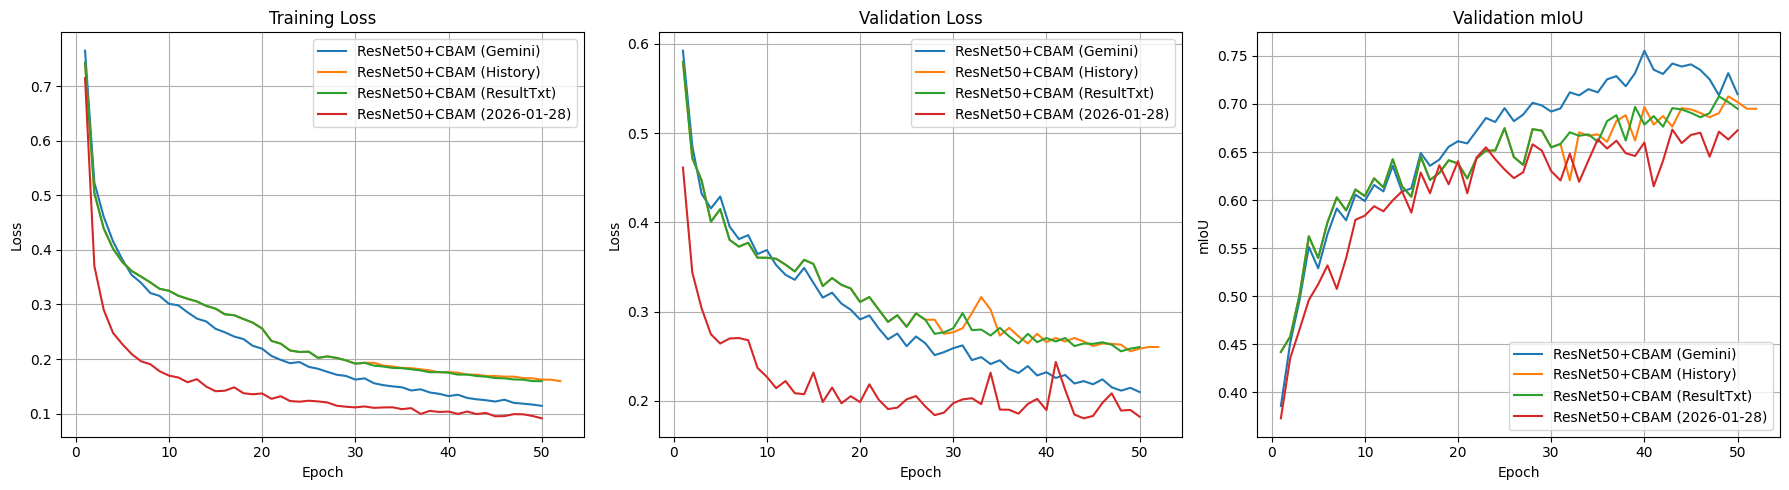

## 画图

正在加载数据...
✓ 数据加载完成，共 49 个epoch

训练结果统计摘要

【DPAI*1】
  初始训练损失: 0.7651
  最终训练损失: 0.1166
  最小训练损失: 0.1166
  初始验证损失: 0.5923
  最终验证损失: 0.2146
  最小验证损失: 0.2114
  初始mIoU:     0.3857
  最终mIoU:     0.7621
  最佳mIoU:     0.7621

【HISTORY】
  初始训练损失: 0.7432
  最终训练损失: 0.1646
  最小训练损失: 0.1646
  初始验证损失: 0.5799
  最终验证损失: 0.2555
  最小验证损失: 0.2555
  初始mIoU:     0.3728
  最终mIoU:     0.6631
  最佳mIoU:     0.6801

【R_CBAM】
  初始训练损失: 0.7432
  最终训练损失: 0.1595
  最小训练损失: 0.1595
  初始验证损失: 0.5799
  最终验证损失: 0.2585
  最小验证损失: 0.2555
  初始mIoU:     0.3919
  最终mIoU:     0.7320
  最佳mIoU:     0.7405

【DPAI*2】
  初始训练损失: 0.7151
  最终训练损失: 0.0957
  最小训练损失: 0.0951
  初始验证损失: 0.4614
  最终验证损失: 0.1898
  最小验证损失: 0.1804
  初始mIoU:     0.4419
  最终mIoU:     0.7079
  最佳mIoU:     0.7079


正在生成综合对比图...
DPAI*1_train_losses
R_CBAM_train_losses
DPAI*2_train_losses


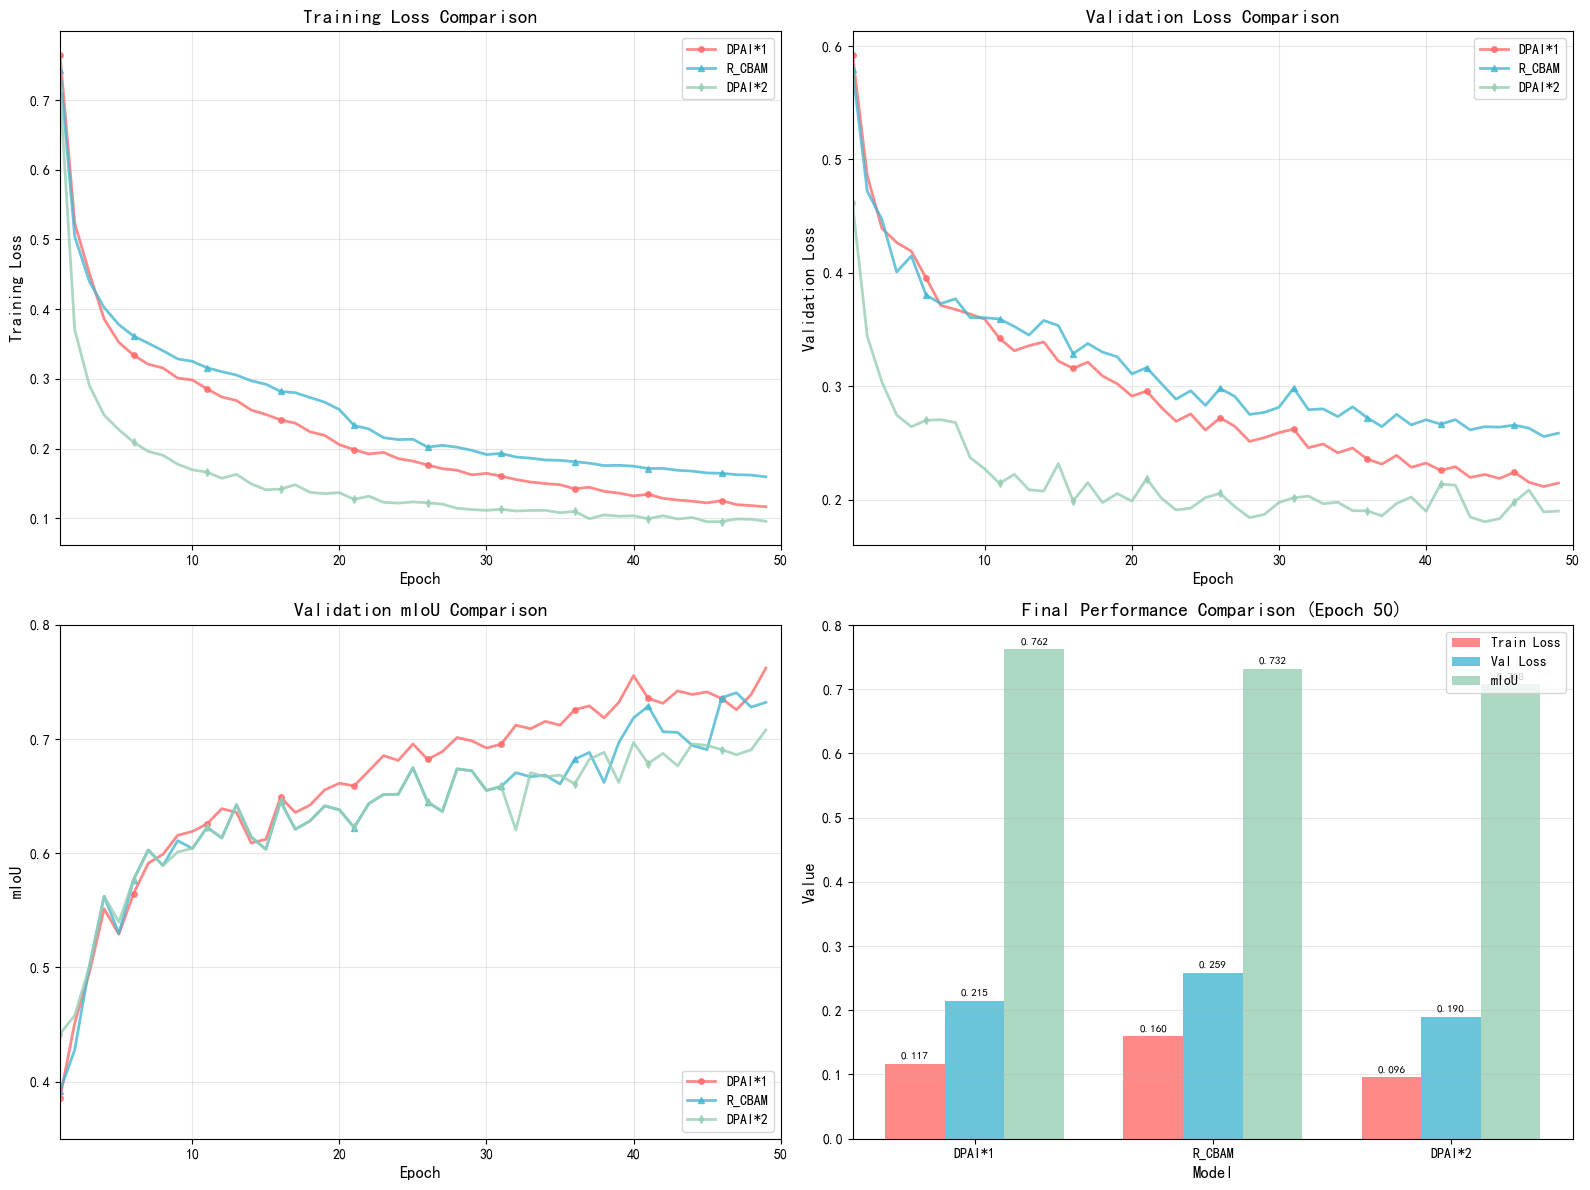

✓ 对比图已保存至: training_comparison.png

正在生成单独模型曲线图...
✓ DPAI*1 单独曲线图已保存至: ./DPAI*1_training_curves.png
✓ HISTORY 单独曲线图已保存至: ./history_training_curves.png
✓ R_CBAM 单独曲线图已保存至: ./R_CBAM_training_curves.png
✓ DPAI*2 单独曲线图已保存至: ./DPAI*2_training_curves.png

正在生成平滑对比图...
✓ 平滑对比图已保存至: smoothed_comparison.png

所有可视化图片生成完成！

生成的文件列表:
  1. training_comparison.png - 四模型综合对比图
  2. DPAI*1_training_curves.png - 双向交互1层模型曲线
  3. history_training_curves.png - History模型曲线
  4. R_CBAM_training_curves.png - R+CBAM模型曲线
  5. DPAI*2_training_curves.png - 双向交互2层模型曲线
  6. smoothed_comparison.png - 平滑处理后的对比图


In [4]:
"""
训练结果可视化脚本
用于展示不同模型的损失和mIoU变化曲线
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


def load_data(csv_path):
    """加载CSV数据"""
    return pd.read_csv(csv_path)


def plot_training_comparison(data, save_path='training_comparison.png', dpi=150):
    """
    绘制训练结果对比图
    包含3个子图：训练损失、验证损失、mIoU
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 定义颜色和样式
    styles = {
        'DPAI*1': {'color': '#FF6B6B', 'linestyle': '-', 'marker': 'o', 'label': 'DPAI*1'},
        # 'history': {'color': '#4ECDC4', 'linestyle': '-', 'marker': 's', 'label': 'History'},
        'R_CBAM': {'color': '#45B7D1', 'linestyle': '-', 'marker': '^', 'label': 'R_CBAM'},
        'DPAI*2': {'color': '#96CEB4', 'linestyle': '-', 'marker': 'd', 'label': 'DPAI*2'}
    }

    epochs = data['epoch']

    # ============== 子图1: 训练损失对比 ==============
    ax1 = axes[0, 0]
    for model_name, style in styles.items():
        col_name = f'{model_name}_train_losses'
        if col_name in data.columns:
            ax1.plot(epochs, data[col_name],
                    color=style['color'],
                    linestyle=style['linestyle'],
                    marker=style['marker'],
                    markersize=4,
                    markevery=5,
                    linewidth=2,
                    alpha=0.8,
                    label=style['label'])

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([1, 50])

    # ============== 子图2: 验证损失对比 ==============
    ax2 = axes[0, 1]
    for model_name, style in styles.items():
        col_name = f'{model_name}_val_losses'
        if col_name in data.columns:
            ax2.plot(epochs, data[col_name],
                    color=style['color'],
                    linestyle=style['linestyle'],
                    marker=style['marker'],
                    markersize=4,
                    markevery=5,
                    linewidth=2,
                    alpha=0.8,
                    label=style['label'])

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Loss', fontsize=12)
    ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([1, 50])

    # ============== 子图3: mIoU对比 ==============
    ax3 = axes[1, 0]
    for model_name, style in styles.items():
        col_name = f'{model_name}_val_miou_history'
        if col_name in data.columns:
            ax3.plot(epochs, data[col_name],
                    color=style['color'],
                    linestyle=style['linestyle'],
                    marker=style['marker'],
                    markersize=4,
                    markevery=5,
                    linewidth=2,
                    alpha=0.8,
                    label=style['label'])

    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('mIoU', fontsize=12)
    ax3.set_title('Validation mIoU Comparison', fontsize=14, fontweight='bold')
    ax3.legend(loc='lower right', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([1, 50])
    ax3.set_ylim([0.35, 0.80])

    # ============== 子图4: 最终性能对比柱状图 ==============
    ax4 = axes[1, 1]

    # 获取最终epoch的性能指标
    models = []
    final_train_loss = []
    final_val_loss = []
    final_miou = []

    for model_name in styles.keys():
        train_col = f'{model_name}_train_losses'
        print(train_col)
        val_col = f'{model_name}_val_losses'
        miou_col = f'{model_name}_val_miou_history'

        if train_col in data.columns:
            models.append(styles[model_name]['label'])
            final_train_loss.append(data[train_col].iloc[-1])
            final_val_loss.append(data[val_col].iloc[-1])
            final_miou.append(data[miou_col].iloc[-1])

    x = np.arange(len(models))
    width = 0.25

    bars1 = ax4.bar(x - width, final_train_loss, width, label='Train Loss',
                   color='#FF6B6B', alpha=0.8)
    bars2 = ax4.bar(x, final_val_loss, width, label='Val Loss',
                   color='#45B7D1', alpha=0.8)
    bars3 = ax4.bar(x + width, final_miou, width, label='mIoU',
                   color='#96CEB4', alpha=0.8)

    ax4.set_xlabel('Model', fontsize=12)
    ax4.set_ylabel('Value', fontsize=12)
    ax4.set_title('Final Performance Comparison (Epoch 50)', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(models, fontsize=10)
    ax4.legend(loc='upper right', fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

    # 在柱状图上添加数值标签
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()
    plt.close()

    print(f"✓ 对比图已保存至: {save_path}")


def plot_individual_metrics(data, save_dir='.'):
    """
    为每个模型单独绘制训练曲线
    """
    models = ['DPAI*1', 'history', 'R_CBAM', 'DPAI*2']

    for model in models:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        train_col = f'{model}_train_losses'
        val_col = f'{model}_val_losses'
        miou_col = f'{model}_val_miou_history'

        if train_col not in data.columns:
            continue

        epochs = data['epoch']

        # 训练损失
        axes[0].plot(epochs, data[train_col], 'b-', linewidth=2, label='Train Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'{model.upper()} - Training Loss')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # 验证损失
        axes[1].plot(epochs, data[val_col], 'r-', linewidth=2, label='Val Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title(f'{model.upper()} - Validation Loss')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        # mIoU
        axes[2].plot(epochs, data[miou_col], 'g-', linewidth=2, label='mIoU')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('mIoU')
        axes[2].set_title(f'{model.upper()} - Validation mIoU')
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()

        plt.tight_layout()

        save_path = f'{save_dir}/{model}_training_curves.png'
        # plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()

        print(f"✓ {model.upper()} 单独曲线图已保存至: {save_path}")


def plot_smoothed_comparison(data, save_path='smoothed_comparison.png', window=5, dpi=150):
    """
    绘制平滑处理后的对比图（使用移动平均）
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    styles = {
        'DPAI*1': {'color': '#FF6B6B', 'label': 'DPAI*1'},
        'history': {'color': '#4ECDC4', 'label': 'History'},
        'R_CBAM': {'color': '#45B7D1', 'label': 'R+CBAM'},
        'DPAI*2': {'color': '#96CEB4', 'label': 'DPAI*2'}
    }

    epochs = data['epoch']

    def smooth(data_series, window):
        """移动平均平滑"""
        return pd.Series(data_series).rolling(window=window, min_periods=1).mean()

    # 训练损失
    ax1 = axes[0]
    for model_name, style in styles.items():
        col_name = f'{model_name}_train_losses'
        if col_name in data.columns:
            raw_data = data[col_name]
            smoothed_data = smooth(raw_data, window)
            ax1.plot(epochs, smoothed_data,
                    color=style['color'], linewidth=2.5,
                    label=style['label'], alpha=0.9)
            ax1.plot(epochs, raw_data,
                    color=style['color'], linewidth=0.8,
                    alpha=0.2)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title(f'Training Loss (Smoothed, window={window})', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # 验证损失
    ax2 = axes[1]
    for model_name, style in styles.items():
        col_name = f'{model_name}_val_losses'
        if col_name in data.columns:
            raw_data = data[col_name]
            smoothed_data = smooth(raw_data, window)
            ax2.plot(epochs, smoothed_data,
                    color=style['color'], linewidth=2.5,
                    label=style['label'], alpha=0.9)
            ax2.plot(epochs, raw_data,
                    color=style['color'], linewidth=0.8,
                    alpha=0.2)

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Loss', fontsize=12)
    ax2.set_title(f'Validation Loss (Smoothed, window={window})', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # mIoU
    ax3 = axes[2]
    for model_name, style in styles.items():
        col_name = f'{model_name}_val_miou_history'
        if col_name in data.columns:
            raw_data = data[col_name]
            smoothed_data = smooth(raw_data, window)
            ax3.plot(epochs, smoothed_data,
                    color=style['color'], linewidth=2.5,
                    label=style['label'], alpha=0.9)
            ax3.plot(epochs, raw_data,
                    color=style['color'], linewidth=0.8,
                    alpha=0.2)

    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('mIoU', fontsize=12)
    ax3.set_title(f'Validation mIoU (Smoothed, window={window})', fontsize=13, fontweight='bold')
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight',
               facecolor='white', edgecolor='none')
    plt.close()

    print(f"✓ 平滑对比图已保存至: {save_path}")


def generate_summary_stats(data):
    """生成统计摘要"""
    models = ['DPAI*1', 'history', 'R_CBAM', 'DPAI*2']
    # models = ['DPAI*1', 'R_CBAM', 'DPAI*2']

    print("\n" + "="*70)
    print("训练结果统计摘要")
    print("="*70)

    for model in models:
        train_col = f'{model}_train_losses'
        val_col = f'{model}_val_losses'
        miou_col = f'{model}_val_miou_history'

        if train_col not in data.columns:
            continue

        print(f"\n【{model.upper()}】")
        print(f"  初始训练损失: {data[train_col].iloc[0]:.4f}")
        print(f"  最终训练损失: {data[train_col].iloc[-1]:.4f}")
        print(f"  最小训练损失: {data[train_col].min():.4f}")
        print(f"  初始验证损失: {data[val_col].iloc[0]:.4f}")
        print(f"  最终验证损失: {data[val_col].iloc[-1]:.4f}")
        print(f"  最小验证损失: {data[val_col].min():.4f}")
        print(f"  初始mIoU:     {data[miou_col].iloc[0]:.4f}")
        print(f"  最终mIoU:     {data[miou_col].iloc[-1]:.4f}")
        print(f"  最佳mIoU:     {data[miou_col].max():.4f}")

    print("\n" + "="*70)


def main():
    """主函数"""
    # 数据路径
    csv_path = './loss/result.csv'

    print("正在加载数据...")
    data = load_data(csv_path)
    print(f"✓ 数据加载完成，共 {len(data)} 个epoch")

    # 生成统计摘要
    generate_summary_stats(data)

    # 绘制综合对比图
    print("\n正在生成综合对比图...")
    plot_training_comparison(data, save_path='training_comparison.png')

    # 绘制单独模型曲线图
    print("\n正在生成单独模型曲线图...")
    plot_individual_metrics(data)

    # 绘制平滑对比图
    print("\n正在生成平滑对比图...")
    plot_smoothed_comparison(data, save_path='smoothed_comparison.png')

    print("\n" + "="*50)
    print("所有可视化图片生成完成！")
    print("="*50)
    print("\n生成的文件列表:")
    print("  1. training_comparison.png - 四模型综合对比图")
    print("  2. DPAI*1_training_curves.png - 双向交互1层模型曲线")
    print("  3. history_training_curves.png - History模型曲线")
    print("  4. R_CBAM_training_curves.png - R+CBAM模型曲线")
    print("  5. DPAI*2_training_curves.png - 双向交互2层模型曲线")
    print("  6. smoothed_comparison.png - 平滑处理后的对比图")


if __name__ == '__main__':
    main()
